In [4]:
import os

import pandas as pd
import numpy as np

import datetime
import time

import requests
from os import listdir
from os.path import isfile, join

from PIL import Image
from io import BytesIO
import cv2
from imageai.Detection import ObjectDetection
from sklearn.preprocessing import MultiLabelBinarizer

from tqdm.notebook import tqdm
tqdm.pandas()

import plotly.express as px
from sklearn.feature_extraction.text import TfidfVectorizer

from instascrape import Profile 
from collections import defaultdict
from googletrans import Translator


## To-do
- [x] Define objects in images
- [x] Add color quantification (features describing hue, saturation, etc. for each image)
- [x] One-hot encode objects
- [x] Calculate wighted number of likes (divided by number of subscriptors)
- [x] Extend dataset up to atleast 5000 records
- [ ] Extend dataset up to atleast 10000 records
- [ ] Add a column with extracted features based on VGG16 model
- [ ] Generate requirments.txt

# 1. Collecting the data

Checking the directory with the scraped post data

In [2]:
pathToPkls = 'scrapedPosts/'
onlyfiles = [f for f in listdir(pathToPkls) if isfile(join(pathToPkls, f))]
onlyfiles

['1622983007_visitcalifornia.pkl',
 '1622922794_coparkswildlife_100.pkl',
 '1622922454_visitdenver.pkl',
 '1621516938_repubblica_milano_100.pkl',
 '1622735079_nytimes.pkl',
 '1621949122_natgeo.pkl',
 '1621950611_iss.pkl',
 '1622921104_visit_berlin.pkl',
 '1622734661_dcim.ru.pkl',
 'milano500.pkl',
 '1621947686_letsdesigndaily.pkl',
 'milanovibra.pkl',
 '1622923687_coparkswildlife.pkl',
 '1622737654_sergeydolya.pkl',
 '1621516759_neontalk.pkl',
 '1622919512_europeanspaceagency.pkl',
 '1621949904_uofdenver.pkl',
 '1622984344_visitseattle.pkl',
 '1622985661_japantravelcom.pkl']

Merging all collected info into single dataframe

In [3]:
dfComplete=pd.DataFrame()
for file in onlyfiles:
    dfComplete = pd.concat([dfComplete,pd.read_pickle(pathToPkls+file)], ignore_index=True)
dfComplete.sample(5)

,id,shortcode,height,width,gating_info,fact_check_overall_rating,fact_check_information,sensitivity_friction_info,media_overlay_info,media_preview,...,has_audio,video_view_count,username,full_name,profile_pic_url,profile_pic_url_hd,upload_date,hashtags,loadTimestamp,timestepOfDownloading
5746,2237979091758571508,B8O5iBrBV_0,1350,1080,None,None,None,None,NaN,None,...,NaN,NaN,sergeydolya,ПУТЕШЕСТВИЯ И ФОТОГРАФИЯ 🇷🇺,https://instagram.fmxp5-1.fna.fbcdn.net/v/t51....,NaN,2020-02-06 17:51:59,"[Уганда, teamtripru, Энтеббе, зеленыемартышки]",1.622737e+09,NaN
2872,2151676205332596353,B3cShvSgoaB,1350,1080,None,None,None,None,None,ACEq2grGl2NUnnRgEllAHXkU5JRIMryB6c1VxWICrj3qMq...,...,NaN,NaN,visit_berlin,visitBerlin,NaN,NaN,2019-10-10 17:03:33,"[wallyourstory, wallyourstory, Mauerfall30, fa...",1.622921e+09,NaN
3917,2469729123866699579,CJGPY2Pguc7,1335,1080,None,None,None,None,None,ACIq2idvU9fWkJJrG3cg9SR/SkEjY2Jksw4GT+Z9hTuKxs...,...,NaN,NaN,milanodavedere,Milano da vedere,NaN,NaN,2020-12-22 13:57:55,[],NaN,NaN
7122,2477181322745975980,CJgt0nSgZSs,1080,1080,None,None,None,None,None,None,...,NaN,NaN,europeanspaceagency,ESA - European Space Agency,NaN,NaN,2021-01-01 18:44:07,[],1.622919e+09,NaN
3529,2555325062702460199,CN2VpsYCG0n,1333,750,None,None,None,None,None,ABcq0c0gYHIByR19qiubhYFyBuJOPSobVtzufpW1zKxaNF...,...,True,14068.0,milanodavedere,Milano da vedere,NaN,NaN,2021-04-19 16:38:55,[milanodavedere],NaN,NaN


# 2. Cleaning the data

## 2.1. Dropping duplicates

In [4]:
#by id and by image urls
dfComplete = dfComplete.drop_duplicates(subset=['id'])
dfComplete = dfComplete.drop_duplicates(subset=['display_url'])

## 2.3. Missing data handling

Some usernames are mising (nan values) for some reason. I had to add them manually.

In [5]:
dfComplete.username.unique()

array(['visitcalifornia', 'coparkswildlife', nan, 'visitdenver',
       'neontalk', 'repubblica_milano', 'nytimes', 'natgeo', 'iss',
       'visit_berlin', 'dcim.ru', 'milanodavedere', 'letsdesigndaily',
       'milanovibra', 'sergeydolya', 'europeanspaceagency', 'uofdenver',
       'visitseattle', 'japantravelcom'], dtype=object)

In [6]:
dfComplete.loc[dfComplete['full_name'].str.contains('80s Aesthetics'), 'username']='neontalk'

In [7]:
dfComplete.loc[dfComplete['full_name'].str.contains('Repubblica'), 'username']='repubblica_milano'

In [8]:
dfComplete.loc[dfComplete['full_name'].str.contains('designdaily'), 'username']='letsdesigndaily'
dfComplete.loc[dfComplete['full_name'].str.contains('MilanoVibra'), 'username']='milanovibra'

In [9]:
dfComplete.loc[dfComplete['full_name'].str.contains('University of Denver'), 'username']='uofdenver'
dfComplete.loc[dfComplete['full_name'].str.contains('Марков'), 'username']='dcim.ru'
dfComplete.loc[dfComplete['full_name'].str.contains('Colorado Parks'), 'username']='coparkswildlife'
dfComplete.loc[dfComplete['full_name'].str.contains('VISIT DENVER'), 'username']='visitdenver'
dfComplete.loc[dfComplete['full_name'].str.contains('Seattle'), 'username']='visitseattle'

In [10]:
dfComplete[dfComplete['username'].isnull()]

,id,shortcode,height,width,gating_info,fact_check_overall_rating,fact_check_information,sensitivity_friction_info,media_overlay_info,media_preview,...,has_audio,video_view_count,username,full_name,profile_pic_url,profile_pic_url_hd,upload_date,hashtags,loadTimestamp,timestepOfDownloading


In [11]:
dfComplete.username.unique()

array(['visitcalifornia', 'coparkswildlife', 'visitdenver', 'neontalk',
       'repubblica_milano', 'nytimes', 'natgeo', 'iss', 'visit_berlin',
       'dcim.ru', 'milanodavedere', 'letsdesigndaily', 'milanovibra',
       'sergeydolya', 'europeanspaceagency', 'uofdenver', 'visitseattle',
       'japantravelcom'], dtype=object)

In [12]:
dfComplete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7179 entries, 0 to 8279
Data columns (total 40 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              7179 non-null   object        
 1   shortcode                       7179 non-null   object        
 2   height                          7179 non-null   int64         
 3   width                           7179 non-null   int64         
 4   gating_info                     0 non-null      object        
 5   fact_check_overall_rating       0 non-null      object        
 6   fact_check_information          0 non-null      object        
 7   sensitivity_friction_info       0 non-null      object        
 8   media_overlay_info              0 non-null      object        
 9   media_preview                   4968 non-null   object        
 10  display_url                     7179 non-null   object        
 11  acce

Checking number posts for each username. It's not so balanced but we will leave it like that to gain more information.

In [13]:
dfComplete.groupby('username').count()['id']

username
coparkswildlife         200
dcim.ru                 496
europeanspaceagency     400
iss                     147
japantravelcom          243
letsdesigndaily         300
milanodavedere          500
milanovibra             980
natgeo                  298
neontalk               1000
nytimes                 126
repubblica_milano       101
sergeydolya             495
uofdenver               298
visit_berlin            396
visitcalifornia         400
visitdenver             399
visitseattle            400
Name: id, dtype: int64

In [15]:
dictSubs = defaultdict()
for un in dfComplete['username'].unique():  
    pf = Profile(un)
    pf.scrape()
    dictSubs[un] = pf.followers
dictSubs


/opt/anaconda3/lib/python3.7/site-packages/instascrape/core/_static_scraper.py:136: MissingCookiesWarning: Request header does not contain cookies! It's recommended you pass at least a valid sessionid otherwise Instagram will likely redirect you to their login page.
  MissingCookiesWarning


defaultdict(None,
            {'visitcalifornia': 589176,
             'coparkswildlife': 169232,
             'visitdenver': 135145,
             'neontalk': 619842,
             'repubblica_milano': 40833,
             'nytimes': 13132611,
             'natgeo': 165871002,
             'iss': 7709150,
             'visit_berlin': 257297,
             'dcim.ru': 886264,
             'milanodavedere': 139288,
             'letsdesigndaily': 473153,
             'milanovibra': 2600,
             'sergeydolya': 142570,
             'europeanspaceagency': 2360780,
             'uofdenver': 22183,
             'visitseattle': 157833,
             'japantravelcom': 147225})

In [17]:
dfComplete['numOfSubs'] = dfComplete['username'].apply(lambda x: dictSubs[x])

In [18]:
dfComplete.to_pickle('instaSeer_dfComplete_nodup_nonan.pkl')
dfComplete.to_csv('instaSeer_dfComplete_nodup_nonan.csv')

## 2.2. Removing videos

In [19]:
dfComplete = dfComplete[dfComplete['is_video']==False]
dfComplete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6240 entries, 0 to 8279
Data columns (total 41 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              6240 non-null   object        
 1   shortcode                       6240 non-null   object        
 2   height                          6240 non-null   int64         
 3   width                           6240 non-null   int64         
 4   gating_info                     0 non-null      object        
 5   fact_check_overall_rating       0 non-null      object        
 6   fact_check_information          0 non-null      object        
 7   sensitivity_friction_info       0 non-null      object        
 8   media_overlay_info              0 non-null      object        
 9   media_preview                   4123 non-null   object        
 10  display_url                     6240 non-null   object        
 11  acce

Dropping columns with more than 20% of null values and then dropping rows with null values. 15 columns were dropped.

In [20]:
dfComplete = dfComplete.dropna(thresh=int(0.8*len(dfComplete)), axis = 1)
dfComplete = dfComplete.dropna()
dfComplete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6122 entries, 0 to 8279
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              6122 non-null   object        
 1   shortcode                       6122 non-null   object        
 2   height                          6122 non-null   int64         
 3   width                           6122 non-null   int64         
 4   display_url                     6122 non-null   object        
 5   accessibility_caption           6122 non-null   object        
 6   is_video                        6122 non-null   bool          
 7   tracking_token                  6122 non-null   object        
 8   tagged_users                    6122 non-null   object        
 9   caption                         6122 non-null   object        
 10  caption_is_edited               6122 non-null   bool          
 11  has_

In [21]:
dfComplete.to_pickle('instaSeer_dfComplete_nodup_nonan_novideos.pkl')
dfComplete.to_csv('instaSeer_dfComplete_nodup_nonan_novideos.csv')

# 3. Feature generation

## 3.1. Calculating new numerical features

In [22]:
dfComplete=dfComplete[~dfComplete['hashtags'].isnull()]
dfComplete['imageRatio'] = dfComplete['width']/dfComplete['height']
dfComplete['numOfHashtags'] = dfComplete['hashtags'].apply(lambda x: len(x))
dfComplete['numOfTaggedUsers'] = dfComplete['tagged_users'].apply(lambda x: len(x))
dfComplete['lenOfCaption'] = dfComplete['caption'].apply(lambda x: len(x))
dfComplete['uploadDayOfWeek'] = dfComplete['upload_date'].apply(lambda x: x.weekday())
#Removing initial columns excecpt captions
dfComplete.drop(columns=['hashtags','tagged_users','is_video','upload_date','width','height'], inplace = True)


## 3.2. Object detection

### 3.2.1. Extracting the objects

Initially I had detector embedded in getObjects function, which slowed df.apply execution. After I moved it out, the effeciency increased by about 30%.

In [23]:
def createDetector(model='yolo.h5'):
    detector = ObjectDetection()
    if 'yolo' in model: 
        detector.setModelTypeAsYOLOv3()
    elif 'resnet' in model:
        detector.setModelTypeAsRetinaNet()
    execution_path = os.getcwd()
    detector.setModelPath( os.path.join(execution_path , model))# "resnet50_coco_best_v2.1.0.h5"))
    detector.loadModel()
    return detector

In [24]:
def getObjects(url, detector):
    """
    The function returns a dictionary of the objects with probabilities detected on the image from url
    based on a given model.
    
    input:
    idx (int): id of an image. Is used for tracking purposes only.
    url (str): url with an image
    model (str): path to a pre-trained object detection model 
    
    output:
    dict: a dictionary of the objects with probabilities detected on the image from url
    based on a given model.
    
    """

    try:
        pth = "imageTemporary.jpg"
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        img.save(pth)
#         

        detections = detector.detectObjectsFromImage(input_image=pth, output_image_path=pth) 
#                                                      output_image_path=os.path.join(execution_path , 
#                                                                                     "imagenew.jpg"))
        return detections
    except:
        return []

In [25]:
%%time
detector = createDetector()
dfComplete['objects']=dfComplete['display_url'].progress_apply(lambda x: getObjects(x, detector))


CPU times: user 7h 26min 23s, sys: 10min 2s, total: 7h 36min 25s
Wall time: 6h 51min 4s


In [26]:
dfComplete.to_csv('instaSeer_dfComplete_objects.csv')
dfComplete.to_pickle('instaSeer_dfComplete_objects.pkl')

### 3.2.2. One hot encoding objects with probabilities over 80%

In [27]:
def extractObjects(x, threshold=80):
    """The function extract objects from dictionary obtained in the previous object detection stage filtering by threshold"""
    lst=[]
    if x!=None and len(x)!=0:
        for obj in x:
            if obj['percentage_probability']>threshold:
                lst.append(obj['name'])
    return list(set(lst))

In [28]:
dfComplete['objectsExtracted'] = dfComplete['objects'].apply(lambda x: extractObjects(x))

mlb = MultiLabelBinarizer(sparse_output=True)
dfComplete = dfComplete.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(dfComplete.pop('objectsExtracted')),
                index=dfComplete.index,
                columns=mlb.classes_))

In [29]:
dfComplete.head()

,id,shortcode,display_url,accessibility_caption,tracking_token,caption,caption_is_edited,has_ranked_comments,comments,comments_disabled,...,tie,toilet,traffic light,train,truck,tv,umbrella,vase,wine glass,zebra
0,2589529678814868574,CPv24XhF3Re,https://instagram.fmxp5-1.fna.fbcdn.net/v/t51....,Photo by visitcalifornia in Disney California ...,eyJ2ZXJzaW9uIjo1LCJwYXlsb2FkIjp7ImlzX2FuYWx5dG...,🎉 🥳 ✨⁣\n⁣\n⬆️ That's us celebrating the openin...,False,True,45,False,...,0,0,0,0,0,0,0,0,0,0
1,2588804972694100788,CPtSGgWMls0,https://instagram.fmxp5-1.fna.fbcdn.net/v/t51....,Photo by visitcalifornia in Rams Hill Golf Clu...,eyJ2ZXJzaW9uIjo1LCJwYXlsb2FkIjp7ImlzX2FuYWx5dG...,What time is it? It's tee-time. If this year's...,False,True,32,False,...,0,0,0,0,0,0,0,0,0,0
2,2588167966001259901,CPrBQ1ojOV9,https://instagram.fmxp5-1.fna.fbcdn.net/v/t51....,"Photo shared by visitcalifornia on June 03, 20...",eyJ2ZXJzaW9uIjo1LCJwYXlsb2FkIjp7ImlzX2FuYWx5dG...,Wake up and smell the jacarandas. If you're an...,False,True,266,False,...,0,0,0,0,0,0,0,0,0,0
3,2587399127907455516,CPoScxXFFIc,https://instagram.fmxp5-1.fna.fbcdn.net/v/t51....,Photo by visitcalifornia in Root Creek Falls w...,eyJ2ZXJzaW9uIjo1LCJwYXlsb2FkIjp7ImlzX2FuYWx5dG...,"Ready to hit the road? Zach O'Brien, founder o...",True,True,70,False,...,0,0,0,0,0,0,0,0,0,0
4,2586703170760562823,CPl0NQwj1iH,https://instagram.fmxp5-1.fna.fbcdn.net/v/t51....,"Photo shared by visitcalifornia on June 01, 20...",eyJ2ZXJzaW9uIjo1LCJwYXlsb2FkIjp7ImlzX2FuYWx5dG...,"No surprise, California is just as beautiful f...",False,True,197,False,...,0,0,0,0,0,0,0,0,0,0


In [30]:
dfComplete.to_csv('instaSeer_dfComplete_objects_filtered.csv')
dfComplete.to_pickle('instaSeer_dfComplete_objects_filtered.pkl')

As a matter of distraction. Found out why:

In [31]:
0.2 + 0.1 == 0.3

False

Should be careful with floats.

## 3.3. Extracting color data
In this section I extract binned histograms for RGB channels for each image. I use 10 bins (from dark to bright).

In [11]:
dfColors = pd.DataFrame()
for i, row in tqdm(dfComplete.iterrows(), total=len(dfComplete)):
    response = requests.get(row['display_url'])
    try:

        img = Image.open(BytesIO(response.content))
        img.save('imageTemporary.jpg')
        pth = "imageTemporary.jpg"
        img = cv2.imread("imageTemporary.jpg")
        color = ('b','g','r')
        dfC = pd.DataFrame()
        for i,col in enumerate(color):
            hist = cv2.calcHist([img],[i],None,[10],[0,256])
            for j, x in enumerate(hist):
                s = np.sum(hist)
                colname = f'{col}_{j}'
                dfC['id'] = row['id']
                dfC['image128'] = [cv2.resize(img,(128,128))]
                dfC[colname]=x/s
        dfColors = pd.concat([dfColors, dfC])
    except:
        pass
dfComplete = dfComplete.merge(dfColors, on='id')

KeyboardInterrupt: 

In [33]:
dfComplete.to_pickle('instaSeer_dfComplete_objects_filtered_colors.pkl')
dfComplete.to_csv('instaSeer_dfComplete_objects_filtered_colors.csv')

## 3.4. Adding vectorized captions

In [12]:
dfComplete = pd.read_pickle('instaSeer_dfComplete_objects_filtered_colors.pkl')
len(dfComplete)

4807

In [ ]:
dfCaptions=pd.read_pickle('instaSeer_dfComplete_nodup_nonan_novideos.pkl')
dfComplete = pd.read_pickle('instaSeer_dfComplete_objects_filtered_colors.pkl')
dfCaptions = dfCaptions[['id','caption','username']].copy()

In [4]:
# dfCaptions = pd.read_pickle('instaSeer_dfComplete_nodup_nonan_novideos.pkl')


#Some of accounts are in other Languauge. I have to translate them
itAccounts = ['repubblica_milano','milanodavedere', 'milanovibra']
ruAccounts = ['dcim.ru', 'sergeydolya']
def transl(x, src, dest='en'):
    translator= Translator()
    try:
        return translator.translate(x, src=src, dest=dest)
    except:
        print('skipped:',x)
        return x



In [2]:
pip install py-translate


     |████████████████████████████████| 61 kB 1.5 MB/s eta 0:00:011
Note: you may need to restart the kernel to use updated packages.


In [9]:
from googletrans import Translator
tralator= Translator()
tralator('привет', 'ru').text

TypeError: 'Translator' object is not callable

In [ ]:
dfCaptions[dfCaptions['username'].isin(ruAccounts)]['caption'] = dfCaptions[dfCaptions['username'].isin(ruAccounts)]['caption'].progress_apply(lambda x: transl(x, 'ru'))

dfCaptions[dfCaptions['username'].isin(itAccounts)]['caption'] = dfCaptions[dfCaptions['username'].isin(itAccounts)]['caption'].progress_apply(lambda x: transl(x, 'it'))


#dfCaptions['caption'] = dfCaptions['caption'].apply(lambda x: ' '.join(str(x).split('\n')))

tc = TfidfVectorizer()
vcz = tc.fit_transform(dfCaptions['caption'])
cols = tc.get_feature_names()
dfCaptions = pd.DataFrame(vcz.todense(), index = list(dfCaptions['id']), columns = cols)
dfCaptions['id'] = dfCaptions.index

In [96]:
dfCaptions['caption']

2589529678814868574    0.0
2588804972694100788    0.0
2588167966001259901    0.0
2587399127907455516    0.0
2586703170760562823    0.0
                      ... 
2467933434911030386    0.0
2467852276208575790    0.0
2467571097785229671    0.0
2466784167502603933    0.0
2466741127475137828    0.0
Name: caption, Length: 6122, dtype: float64

In [92]:
dfComplete = dfComplete.merge(dfCaptions, on='id')

In [93]:
dfComplete.to_pickle('instaSeer_dfComplete_objects_filtered_colors_captions.pkl')

## 3.4. Adding weighted likes

In [49]:
dfL = pd.read_pickle('instaSeer_dfComplete_nodup_nonan_novideos.pkl')
dfComplete = pd.read_pickle('instaSeer_dfComplete_objects_filtered_colors_captions.pkl')
dfL['likesX']=dfL['likes']

In [51]:
dfComplete = dfComplete.merge(dfL[['id','likesX','username']], on='id')

In [13]:
dfComplete['weightedLikes']=dfComplete['likes']/dfComplete['numOfSubs']

In [14]:
dfComplete.to_pickle('instaSeer_dfComplete_objects_filtered_colors_wlikes.pkl')

In [15]:
dfComplete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4807 entries, 0 to 4806
Columns: 129 entries, id to weightedLikes
dtypes: Sparse[int64, 0](70), bool(9), float32(30), float64(2), int64(8), object(10)
memory usage: 1.4+ MB


# 4. Dataset adjustments for models and saving

In [2]:
# dfComplete = pd.read_pickle('instaSeer_dfComplete_objects_filtered_colors_wlikes.pkl')

## 4.1. Dataset for regression 

In [67]:
columnsToRemove = ['shortcode','display_url','tracking_token','caption_is_edited',
                   'has_ranked_comments', 'caption',
                    'comments',
                   'comments_disabled','commenting_disabled_for_viewer',
                   'timestamp','viewer_has_liked','viewer_has_saved','viewer_has_saved_to_collection',
                   'viewer_in_photo_of_you','viewer_can_reshare',
                   'username',
                   'full_name',
                    'likes', 'objects',
                    'image128', 'id',
                   'numOfSubs','accessibility_caption']

In [68]:
dfRegression = dfComplete.copy()
dfRegression.drop(columns=columnsToRemove, inplace = True)

In [83]:
dfRegression.columns

Index(['imageRatio', 'numOfHashtags', 'numOfTaggedUsers', 'lenOfCaption',
       'uploadDayOfWeek', 'airplane', 'apple', 'backpack', 'bear', 'bed',
       ...
       'r_2', 'r_3', 'r_4', 'r_5', 'r_6', 'r_7', 'r_8', 'r_9', 'weightedLikes',
       'logWeightedLikes'],
      dtype='object', length=107)

<AxesSubplot:>

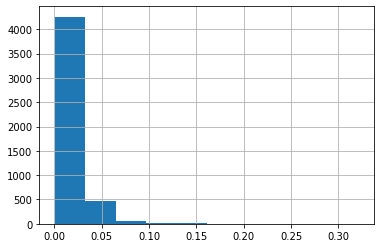

In [69]:
dfRegression['weightedLikes'].hist()

In [70]:
dfRegression['logWeightedLikes'] = np.log(dfRegression['weightedLikes'])

<AxesSubplot:>

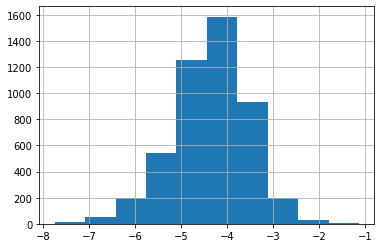

In [71]:
dfRegression['logWeightedLikes'].hist()

In [72]:
dfRegression.to_pickle('instaSeer_dfRegression.pkl')


In [73]:
# dfRegression = pd.read_pickle('instaSeer_dfRegression.pkl')

In [74]:
f=px.histogram(np.log(dfRegression['weightedLikes']), title = 'log(weightedLikes) distribution')
f.update_layout(showlegend=False)

In [75]:
from scipy.stats import shapiro
shapiro(np.log(dfRegression['weightedLikes']))

ShapiroResult(statistic=0.9894884824752808, pvalue=1.8894676686847053e-18)

In [86]:
dfClassification.dropna(inplace=True)

In [88]:
px.histogram(dfClassification['weightedLikes'], color=dfClassification['weightedLikes'], title='Binning with 5 equal bins')

In [89]:
dfClassification = dfRegression.copy()
numOfCategories = 5
labels = range(numOfCategories)
dfClassification['weightedLikes'] = pd.qcut(dfClassification['weightedLikes'], q=5, labels=labels)

In [90]:
px.histogram(dfClassification['weightedLikes'], color=dfClassification['weightedLikes'], title='Binning with quantile-based discretization function')

## 4.2. Dataset for classification 

In [76]:
dfClassification = dfRegression.copy()

<AxesSubplot:>

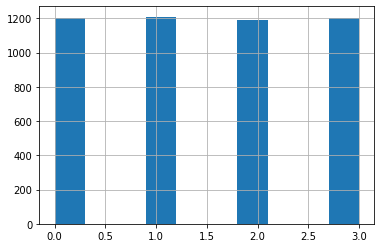

In [77]:
# dfClassification.drop(columns=['logWeightedLikes'], inplace=True)
# dfClassification = dfClassification[dfClassification['weightedLikes']<0.02]
# dfClassification = dfClassification[dfClassification['weightedLikes']>0.005]
# dfClassification['weightedLikes']=np.log(dfClassification['weightedLikes'])
numOfCategories = 4
# bins = np.linspace(np.min(dfClassification['weightedLikes']), 
#                    np.max(dfClassification['weightedLikes']),
#                    numOfCategories).reshape(-1)
# labels = range(numOfCategories-1)
# dfClassification['weightedLikes'] = pd.cut(dfClassification['weightedLikes'], bins=bins, labels=labels)

labels = range(numOfCategories)
dfClassification['weightedLikes'] = pd.qcut(dfClassification['weightedLikes'], q=numOfCategories, labels=labels)

# mn = np.mean(dfClassification['weightedLikes'])
# dfClassification['weightedLikes'] = dfClassification['weightedLikes'].apply(lambda x: 0 if x<mn else 1)
dfClassification.dropna(inplace=True)
dfClassification['weightedLikes'].hist()
# dfB.iloc[:,-1] = dfB.iloc[:,-1].astype(int) #Need this because pd.cut produces categorical type

In [78]:
# numOfCategories = 6
# bins = np.linspace(np.min(dfClassification['weightedLikes']), 
#                    np.max(dfClassification['weightedLikes']),
#                    numOfCategories).reshape(-1)
# labels = range(numOfCategories-1)
# dfClassification['weightedLikes'] = pd.cut(dfClassification['weightedLikes'], bins=bins, labels=labels)


In [79]:
dfClassification.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4807 entries, 0 to 4806
Columns: 107 entries, imageRatio to logWeightedLikes
dtypes: Sparse[int64, 0](70), category(1), float32(30), float64(2), int64(4)
memory usage: 870.9 KB


In [80]:
dfClassification.to_pickle('instaSeer_dfClassification.pkl')
# dfClassification.to_csv('instaSeer_dfClassification.csv')

## 4.3. Dataset for NN classification 

In [81]:
dfNN = dfComplete[['image128','weightedLikes']].copy()

<AxesSubplot:>

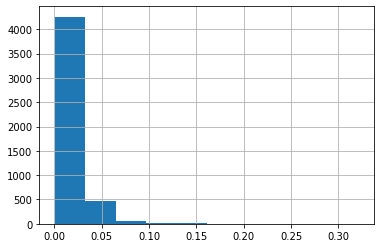

In [82]:
dfNN['weightedLikes'].hist()

In [39]:
numOfCategories = 4

# bins = np.linspace(np.min(dfNN['weightedLikes']), np.max(dfNN['weightedLikes']),numOfCategories).reshape(-1)
labels = range(numOfCategories)
dfNN['weightedLikes'] = pd.qcut(dfNN['weightedLikes'], q=4, labels=labels)
dfNN.dropna(inplace=True)

<AxesSubplot:>

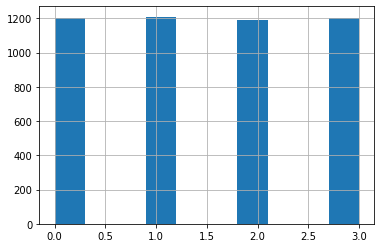

In [40]:
dfNN['weightedLikes'].hist()

In [41]:
dfNN.groupby(by='weightedLikes').count()

,image128
weightedLikes,
0,1202
1,1210
2,1193
3,1202


In [42]:
dfNN.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4807 entries, 0 to 4806
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   image128       4807 non-null   object  
 1   weightedLikes  4807 non-null   category
dtypes: category(1), object(1)
memory usage: 79.9+ KB


In [43]:
dfNN.to_pickle('instaSeer_dfNN.pkl')
dfNN.to_csv('instaSeer_dfNN.csv')

# 5. Some visualizations

In [ ]:
wlCorr = dfComplete.corr()['weightedLikes']

In [ ]:
f=px.bar(wlCorr[wlCorr>=0].sort_values()[:int(len(wlCorr[wlCorr>=0])/2)], 
       title='Positive correlation with weighted likes')
f.update_xaxes(tickangle=-45)

In [ ]:
f = px.bar(wlCorr[wlCorr<0].sort_values()[:int(len(wlCorr[wlCorr<0])/2)][::-1], 
       title='Negative correlation with weighted likes')
f.update_xaxes(tickangle=-45)